# 🧮 Black-Scholes Options Pricer
*Built by Katia Nkurunziza*

A Python implementation of the Black-Scholes model to price European call and put options, visualize sensitivities, and explore financial insights.

## Introduction

The Black-Scholes model is a mathematical model used for pricing European options. It assumes that markets are efficient and that the price of the underlying asset follows a geometric Brownian motion.

In this notebook, we:
- Implement the Black-Scholes formula for call and put options.
- Visualize how option prices vary with underlying parameters.
- Compare theoretical prices with real market data.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

In [13]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

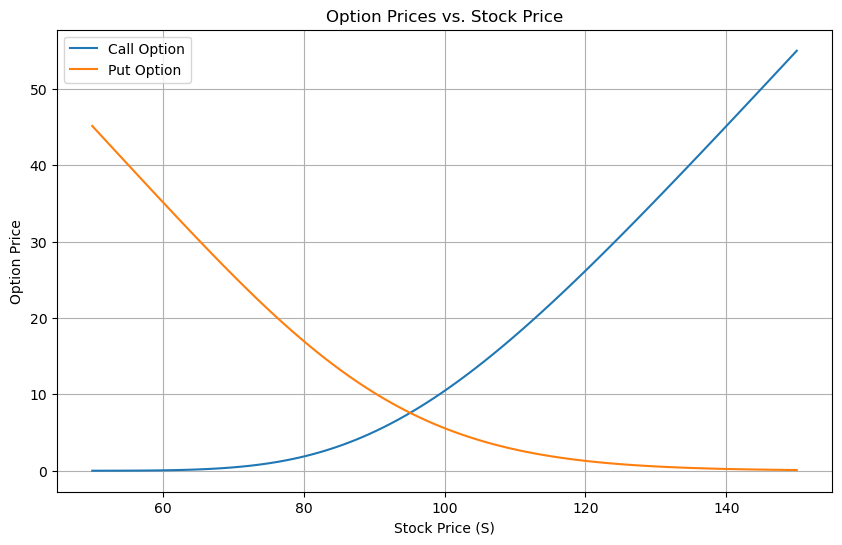

In [14]:
S_range = np.linspace(50, 150, 100)
K = 100
T = 1
r = 0.05
sigma = 0.2

call_prices = [black_scholes_call(S, K, T, r, sigma) for S in S_range]
put_prices = [black_scholes_put(S, K, T, r, sigma) for S in S_range]

plt.figure(figsize=(10, 6))
plt.plot(S_range, call_prices, label='Call Option')
plt.plot(S_range, put_prices, label='Put Option')
plt.title('Option Prices vs. Stock Price')
plt.xlabel('Stock Price (S)')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()

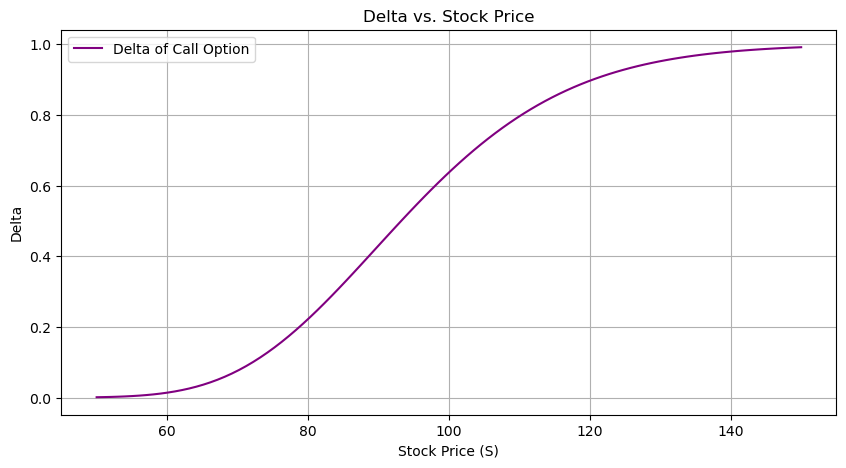

In [15]:
def delta_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

delta_vals = [delta_call(S, K, T, r, sigma) for S in S_range]

plt.figure(figsize=(10, 5))
plt.plot(S_range, delta_vals, label='Delta of Call Option', color='purple')
plt.title('Delta vs. Stock Price')
plt.xlabel('Stock Price (S)')
plt.ylabel('Delta')
plt.grid(True)
plt.legend()
plt.show()

## 📊 Comparing Black-Scholes Price with Yahoo Finance Data

Let's pull real stock option data using `yfinance` and compare it to our model's theoretical prices.


In [21]:

import yfinance as yf
from datetime import datetime

# Define parameters
ticker = 'AAPL'
expiration = '2025-05-23'
option_type = 'call'  # 'put' also works

# Get option chain
stock = yf.Ticker(ticker)
opt_chain = stock.option_chain(expiration)
options = opt_chain.calls if option_type == 'call' else opt_chain.puts

# Choose a strike closest to current stock price
current_price = stock.history(period='1d')['Close'].iloc[-int(1)]
# Ensure closest_idx is an integer
closest_idx = (options['strike'] - current_price).abs().values.argmin()
closest_strike = options.iloc[closest_idx]

# Extract parameters
S = current_price
K = closest_strike['strike']
T = (datetime.strptime(expiration, "%Y-%m-%d") - datetime.now()).days / 365
r = 0.05  # Assume 5% interest rate
sigma = stock.history(period='1y')['Close'].pct_change().std() * (252**0.5)  # Annualized volatility

# Calculate theoretical price
bs_price = black_scholes_call(S, K, T, r, sigma) if option_type == 'call' else black_scholes_put(S, K, T, r, sigma)

# Compare
market_price = closest_strike['lastPrice']
print(f"{ticker} {option_type.capitalize()} Option expiring {expiration} at strike {K}")
print(f"Current Stock Price: ${S:.2f}")
print(f"Market Option Price: ${market_price:.2f}")
print(f"Black-Scholes Price: ${bs_price:.2f}")
print(f"Volatility Used: {sigma:.2%}")


AAPL Call Option expiring 2025-05-23 at strike 207.5
Current Stock Price: $206.86
Market Option Price: $2.05
Black-Scholes Price: $1.14
Volatility Used: 33.03%


## 🔍 Market vs. Black-Scholes Option Prices

This section compares the **theoretical option prices** calculated using the Black-Scholes model to **real market prices** obtained from Yahoo Finance via `yfinance`.

We use options with the same expiration date and compare across various strike prices. This helps assess how closely the Black-Scholes model reflects actual market behavior.

Key assumptions:
- Constant interest rate (5%)
- Historical volatility over the past year
- European-style exercise (no early exercise)

The plot shows:
- Blue line: Market prices from the options chain
- Orange line: Theoretical prices from Black-Scholes
- Dashed line: Current stock price

Notice that discrepancies may occur due to:
- Market inefficiencies
- Bid-ask spreads
- Implied volatility not matching historical volatility


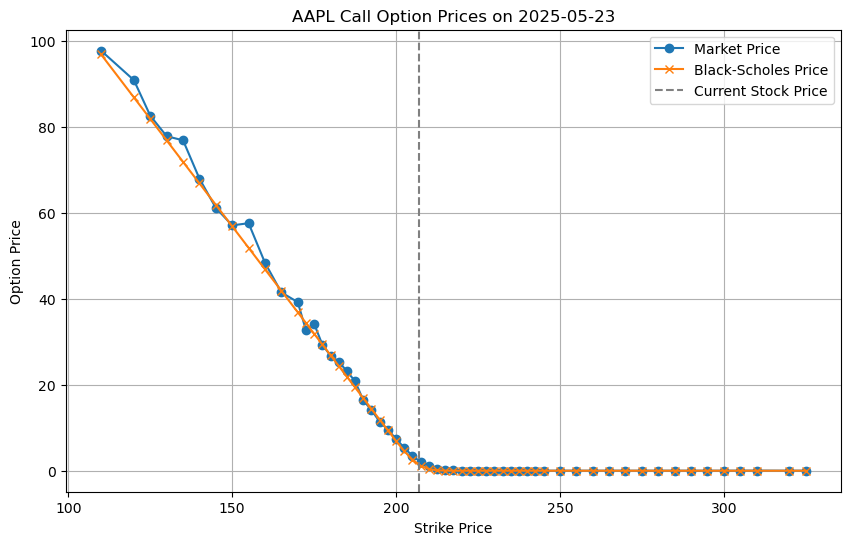

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Loop through all strike prices in the option chain
strikes = options['strike'].values
market_prices = options['lastPrice'].values
bs_prices = []

for i, K in enumerate(strikes):
    T = (datetime.strptime(expiration, "%Y-%m-%d") - datetime.now()).days / 365
    bs = black_scholes_call(S, K, T, r, sigma) if option_type == 'call' else black_scholes_put(S, K, T, r, sigma)
    bs_prices.append(bs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(strikes, market_prices, label="Market Price", marker='o')
plt.plot(strikes, bs_prices, label="Black-Scholes Price", marker='x')
plt.axvline(S, color='gray', linestyle='--', label='Current Stock Price')
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title(f"{ticker} {option_type.capitalize()} Option Prices on {expiration}")
plt.legend()
plt.grid(True)
plt.show()


## 📊 Implied Volatility vs. Historical Volatility

Black-Scholes uses volatility as an input — but in practice, **volatility is unknown** and inferred from market prices. This leads to the concept of **implied volatility**.

In this section:
- We solve for the volatility that makes the Black-Scholes price equal the market price for each strike.
- We compare it to the historical volatility over the past year.

Key insights:
- If the implied volatility is much higher than historical, the market may be pricing in upcoming uncertainty (e.g., earnings, macro events).
- A flat implied volatility curve suggests market consensus; a skewed curve indicates market sentiment.

The plot:
- Orange line: Historical (constant) volatility used earlier
- Blue line: Implied volatilities from market prices


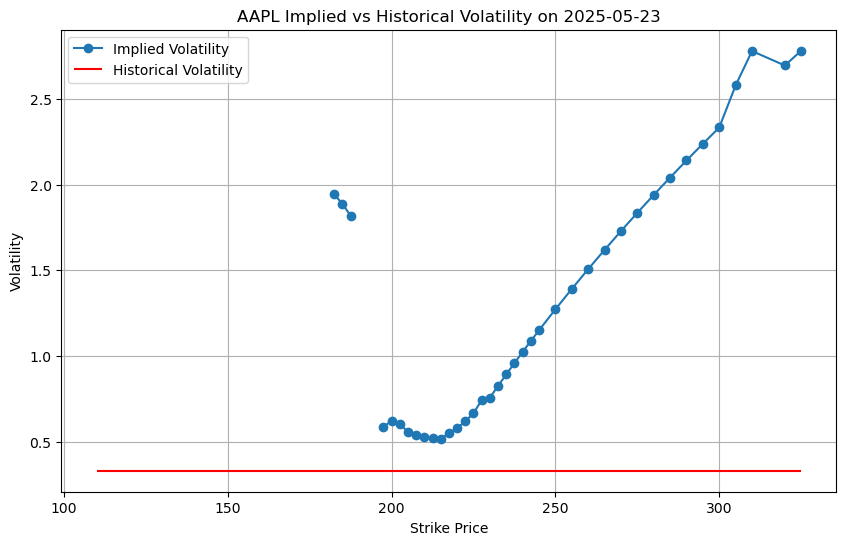

In [24]:
from scipy.optimize import brentq

def implied_volatility(market_price, S, K, T, r, option_type='call'):
    def objective(sigma):
        if option_type == 'call':
            return black_scholes_call(S, K, T, r, sigma) - market_price
        else:
            return black_scholes_put(S, K, T, r, sigma) - market_price
    try:
        return brentq(objective, 1e-6, 3)
    except ValueError:
        return np.nan

implied_vols = [implied_volatility(mp, S, K, T, r, option_type)
                for mp, K in zip(market_prices, strikes)]

# Plot implied vs historical
plt.figure(figsize=(10, 6))
plt.plot(strikes, implied_vols, label='Implied Volatility', marker='o')
plt.hlines(sigma, min(strikes), max(strikes), colors='red', label='Historical Volatility')
plt.xlabel("Strike Price")
plt.ylabel("Volatility")
plt.title(f"{ticker} Implied vs Historical Volatility on {expiration}")
plt.legend()
plt.grid(True)
plt.show()


## 🧠 Why Compare Market and Model?

These comparisons help us:
- Identify **mispriced options**
- Understand **market sentiment** and expectations
- Improve our own pricing strategies

In practice, models like Black-Scholes are useful but not perfect:
- They assume constant volatility and interest rates
- They don't account for real-world factors like dividends, early exercise, or stochastic volatility

By contrasting theory with reality, we build better **intuition as quants or traders**, and learn when to trust models — and when to question them.

## Conclusion

This notebook demonstrates a core quantitative finance technique using Python:
- We implemented the Black-Scholes pricing model.
- We visualized how option prices respond to changes in market parameters.
- We introduced the Delta "Greek" as a measure of price sensitivity.
- We pulled real stock data to explore practical applications.

Next steps could include:
- Implementing more Greeks (Gamma, Vega, Theta, Rho)
- Pricing American options (via binomial trees)
- Adding implied volatility estimation